In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))

# 02/Sep/2020 11:55

In [2]:
%%capture
# %matplotlib inline

# Dependences
from time import time
# import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import numpy as np

# Experiments
import run

In [ ]:
# @dev Pricing function for converting between ETH and Tokens.
# @param input_amount Amount of ETH or Tokens being sold.
# @param input_reserve Amount of ETH or Tokens (input type) in exchange reserves.
# @param output_reserve Amount of ETH or Tokens (output type) in exchange reserves.
# @return Amount of ETH or Tokens bought.
def getOutputAmount(input_amount, input_reserve, output_reserve, params, price=False):
    fee_numerator = params['fee_numerator']
    fee_denominator = params['fee_denominator']
    input_amount_with_fee = input_amount * fee_numerator
    numerator = input_amount_with_fee * output_reserve
    denominator = (input_reserve * fee_denominator) + input_amount_with_fee
    output_amount = int(numerator // denominator)
    if(price):
        return int(input_amount // output_amount) # confuse?
    else:
        return output_amount

getOuputAmount(..., price=True) <= real_price * (1 - epslon)

real_price = getOutputAmount(params has to be the real data from the df)
model_price = getOutputAmount(params had to be calculed to be the optmal values) <-> problema

    input amount -  tem que descobrir (muda dependendo de onde o preco esta pra onde vai ser levado) para isso, usar os dados de balance depois da transacao original, para sbaer pra onde o modelo vai, e analisar o caso para ver qual a transacao que o trader precisa fazer
    input reserve - tem no df (muda dependendo de onde o preco esta pra onde vai ser levado)
    output reerve - tem no df (muda dependendo de onde o preco esta pra onde vai ser levado)


In [3]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
start_time = time()
experiments = run.run()
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: multi_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (147437, 3, 1, 3)
Execution Method: single_proc_exec
Execution Mode: single_threaded
Total execution time: 6.48s
Execution in 6.7s


## ANALYSIS

In [8]:
model_history = experiments[['DAI_balance', 'ETH_balance', 'UNI_supply']]
model_history.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']

In [10]:
UNI_df = pd.read_pickle()
real_history = UNI_df.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']

<AxesSubplot:>

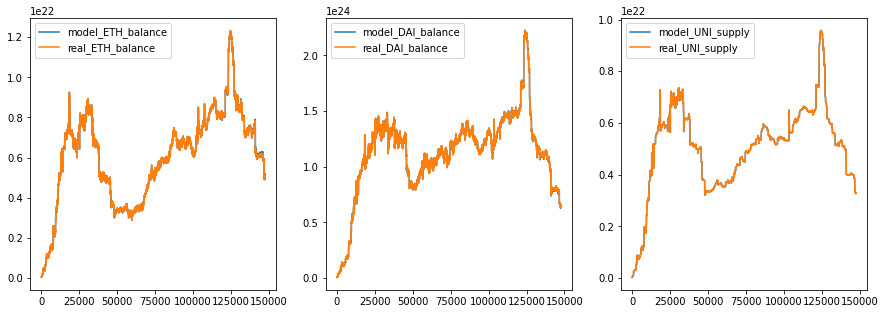

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
model_history.astype(float).plot(ax=ax, y=['model_ETH_balance'])
real_history.astype(float).plot(ax=ax, y=['real_ETH_balance'])
ax = plt.subplot(132)
model_history.astype(float).plot(ax=ax, y=['model_DAI_balance'])
real_history.astype(float).plot(ax=ax, y=['real_DAI_balance'])
ax = plt.subplot(133)
model_history.astype(float).plot(ax=ax, y=['model_UNI_supply'])
real_history.astype(float).plot(ax=ax, y=['real_UNI_supply'])

In [13]:
model_history.tail(1)

,model_DAI_balance,model_ETH_balance,model_UNI_supply
147437,655398639698980968543553,5088972909434012930085,3308419107140103200194


In [14]:
real_history.tail(1)

,real_DAI_balance,real_ETH_balance,real_UNI_supply
147437,662323537318822558984586,5009819142181678051370,3304234867026987131356


In [15]:
model_history.iloc[-1]['model_DAI_balance']/real_history.iloc[-1]['real_DAI_balance']

0.9895445394438577

In [16]:
model_history.iloc[-1]['model_ETH_balance']/real_history.iloc[-1]['real_ETH_balance']

1.0157997255002433

In [17]:
model_history.iloc[-1]['model_UNI_supply']/real_history.iloc[-1]['real_UNI_supply']

1.001266326481471